# LeNet-5

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

import torchvision.transforms as T
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

In [18]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE=32

In [19]:
transform = T.Compose([T.Resize((32, 32)), T.ToTensor()])

In [20]:
train_val_dataset = MNIST(root="../datasets/", train=True, download=True, transform=transform)
test_dataset = MNIST(root="../datasets/", train=False, download=False, transform=transform)

In [21]:
train_idxs, val_idxs = train_test_split(
                                range(len(train_val_dataset)),
                                test_size=0.1)

In [22]:
labels = train_val_dataset.targets.numpy()
indices = list(range(len(train_val_dataset)))
train_idxs, val_idxs = train_test_split(indices,
                                              test_size=0.1,
                                              stratify=labels)

In [23]:
train_dataset = Subset(train_val_dataset, train_idxs)
val_dataset = Subset(train_val_dataset, val_idxs)

In [24]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)

In [25]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        
    def forward(self, features):
        features = self.feature_extractor(features)
        logits = self.classifier(features)
        return logits

In [26]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = model(features)
            
            predictions = logits.max(dim=1)[1]
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In [27]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

In [28]:
def train(num_epochs, train_dataloader, val_dataloader, model, criterion, optimizer):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    model.to(DEVICE)
    for epoch in range(num_epochs):
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            model.train()
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # Empty the gradients
            optimizer.zero_grad()
            
            # Forward Pass
            logits = model(features)
            
            # Calculate Loss
            loss = criterion(logits, labels)
            
            # Backward Pass
            loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f'Epoch: {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
    return history            
            

In [29]:
model = Model()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [30]:
history = train(10, train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch:  1/10 | Train Loss: 0.00258 | Val Loss: 0.00314 | Train Acc: 0.974 | Val Acc: 0.968
Epoch:  2/10 | Train Loss: 0.00189 | Val Loss: 0.00246 | Train Acc: 0.982 | Val Acc: 0.974
Epoch:  3/10 | Train Loss: 0.00126 | Val Loss: 0.00194 | Train Acc: 0.987 | Val Acc: 0.981
Epoch:  4/10 | Train Loss: 0.00074 | Val Loss: 0.00131 | Train Acc: 0.993 | Val Acc: 0.986
Epoch:  5/10 | Train Loss: 0.00073 | Val Loss: 0.00161 | Train Acc: 0.993 | Val Acc: 0.985
Epoch:  6/10 | Train Loss: 0.00051 | Val Loss: 0.00114 | Train Acc: 0.995 | Val Acc: 0.989
Epoch:  7/10 | Train Loss: 0.00059 | Val Loss: 0.00147 | Train Acc: 0.994 | Val Acc: 0.987
Epoch:  8/10 | Train Loss: 0.00049 | Val Loss: 0.00150 | Train Acc: 0.995 | Val Acc: 0.986
Epoch:  9/10 | Train Loss: 0.00037 | Val Loss: 0.00137 | Train Acc: 0.996 | Val Acc: 0.989
Epoch: 10/10 | Train Loss: 0.00037 | Val Loss: 0.00154 | Train Acc: 0.996 | Val Acc: 0.987


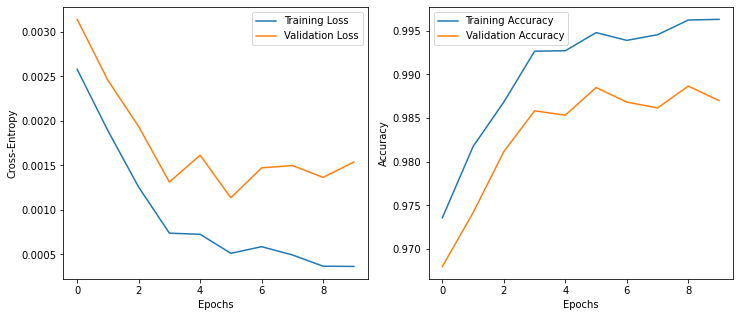

In [31]:
plot_history(history)

In [32]:
test_loss, test_acc = track_performance(test_dataloader, model, criterion)

In [33]:
print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}')

Test Loss: 0.00116 | Test Acc: 0.990
